## UNET CNN

In [1]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping

In [2]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

In [28]:
fieldMNIST, targetMNIST, freqMNIST = readData(path = "./EMNIST_img/", getTargetName=False)

fieldMNIST_transformed = np.reshape(fieldMNIST, (fieldMNIST.shape[0], fieldMNIST.shape[1], fieldMNIST.shape[2], 1))
targetMNIST_transformed = np.reshape(targetMNIST, (targetMNIST.shape[0], targetMNIST.shape[1], targetMNIST.shape[2], 1))

fieldMNIST_train, fieldMNIST_test, targetMNIST_train, targetMNIST_test= train_test_split(
    fieldMNIST_transformed, targetMNIST_transformed, test_size=0.20, random_state=42)

fieldMNIST_train, fieldMNIST_val, targetMNIST_train, targetMNIST_val= train_test_split(
    fieldMNIST_train, targetMNIST_train, test_size=0.20, random_state=42)

Read 630 samples


In [4]:
[fieldMNIST_train.shape,targetMNIST_train.shape, fieldMNIST_val.shape, targetMNIST_val.shape]

[(403, 24, 24, 1), (403, 28, 28, 1), (101, 24, 24, 1), (101, 28, 28, 1)]

In [4]:
fieldMNIST_train_padded = np.pad(fieldMNIST_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_val_padded = np.pad(fieldMNIST_val, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_test_padded = np.pad(fieldMNIST_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

In [6]:
[fieldMNIST_train_padded.shape,targetMNIST_train.shape, fieldMNIST_val_padded.shape, targetMNIST_val.shape]

[(403, 28, 28, 1), (403, 28, 28, 1), (101, 28, 28, 1), (101, 28, 28, 1)]

In [5]:
def unet_padded(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # # skip2 = Concatenate(axis=-1)([conv1, up2])
    # conv5 = Conv2D(32, 3, padding='same')(up3)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)
    # conv5 = Conv2D(32, 3, padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)

    output = Conv2D(1, 1, activation='sigmoid')(conv4)

    # output = Conv2D(n_class, 1, activation='softmax')(conv4)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)
    # skip3 = Concatenate(axis=-1)([input, cropped_output])


    model = Model(inputs=inputs, outputs=output)

    return model

In [8]:
inputMNIST_shape_padded = fieldMNIST_train_padded.shape[1:]
model_mnist_padded = unet_padded(inputMNIST_shape_padded)
model_mnist_padded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 28, 28, 64)   640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 28, 28, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_11[0]

In [9]:
model_mnist_padded.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6), loss = 'binary_crossentropy', 
                    metrics = 'accuracy')
hist_padded2 = model_mnist_padded.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 20, epochs = 200, 
                                    callbacks = [EarlyStopping(monitor='loss',patience=10)])

Epoch 1/200
21/21 [==============================] - 16s 717ms/step - loss: 0.8081 - accuracy: 0.4628 - val_loss: 0.6911 - val_accuracy: 0.6036
Epoch 2/200
21/21 [==============================] - 16s 723ms/step - loss: 0.7993 - accuracy: 0.4757 - val_loss: 0.6876 - val_accuracy: 0.6296
Epoch 3/200
21/21 [==============================] - 14s 647ms/step - loss: 0.7903 - accuracy: 0.4895 - val_loss: 0.6831 - val_accuracy: 0.6456
Epoch 4/200
21/21 [==============================] - 14s 659ms/step - loss: 0.7827 - accuracy: 0.5025 - val_loss: 0.6780 - val_accuracy: 0.6623
Epoch 5/200
21/21 [==============================] - 12s 570ms/step - loss: 0.7750 - accuracy: 0.5141 - val_loss: 0.6728 - val_accuracy: 0.6663
Epoch 6/200
21/21 [==============================] - 11s 539ms/step - loss: 0.7680 - accuracy: 0.5247 - val_loss: 0.6677 - val_accuracy: 0.6652
Epoch 7/200
21/21 [==============================] - 12s 577ms/step - loss: 0.7610 - accuracy: 0.5351 - val_loss: 0.6629 - val_accuracy:

In [ ]:
model_mnist_padded.save('unet_testing.h5', overwrite=True)

trained_model_cross_entropy = load_model('unet_testing.h5')

In [12]:
pred3 = model_mnist_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 1s 138ms/step


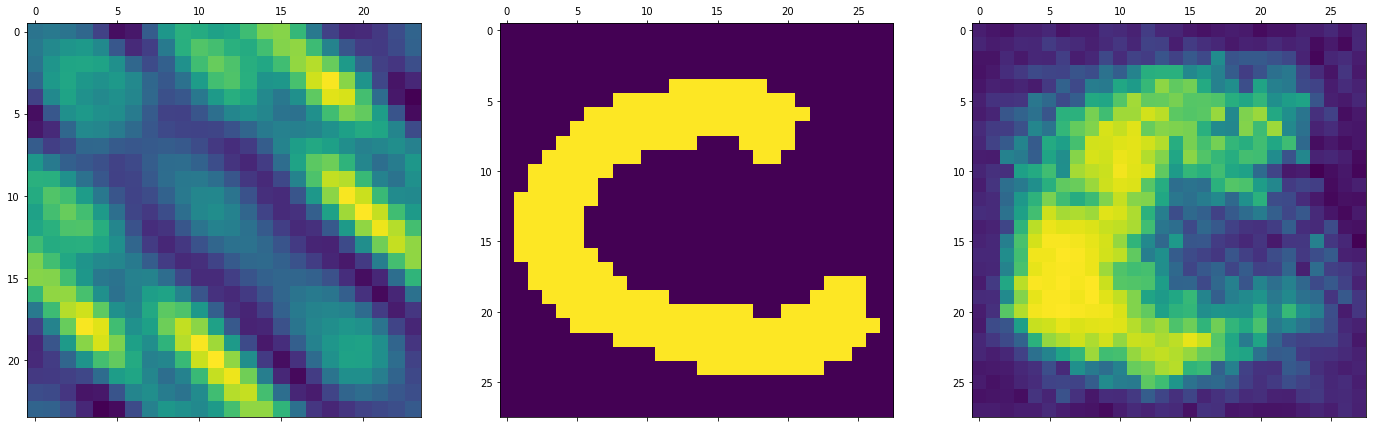

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[50])
axs[1].matshow(targetMNIST_test[50])
axs[2].matshow(pred3[50])

plt.show()

In [14]:
model_mnist_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)

4/4 [==============================] - 1s 119ms/step - loss: 0.3850 - accuracy: 0.8549


[0.3850353956222534, 0.8548651337623596]

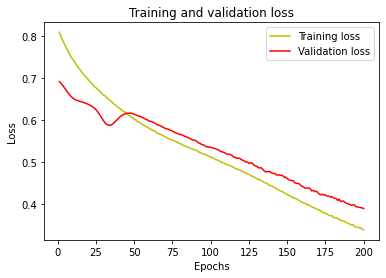

In [10]:
loss = hist_padded2.history['loss']
val_loss = hist_padded2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

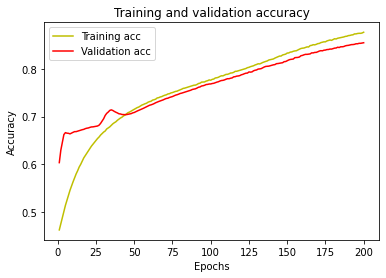

In [11]:
acc = hist_padded2.history['accuracy']
val_acc = hist_padded2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
def unet_padded2(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # # skip2 = Concatenate(axis=-1)([conv1, up2])
    # conv5 = Conv2D(32, 3, padding='same')(up3)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)
    # conv5 = Conv2D(32, 3, padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)

    output = Conv2D(1, 1, activation='softmax')(conv4)

    # output = Conv2D(n_class, 1, activation='softmax')(conv4)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)
    # skip3 = Concatenate(axis=-1)([input, cropped_output])


    model = Model(inputs=inputs, outputs=output)

    return model

In [25]:
inputMNIST_shape_padded = fieldMNIST_train_padded.shape[1:]
model_mnist_padded2 = unet_padded2(inputMNIST_shape_padded)
model_mnist_padded2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 28, 28, 64)   640         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_77 (BatchN  (None, 28, 28, 64)  256         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_77[0]

In [26]:
model_mnist_padded2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6), loss = 'binary_crossentropy', 
                    metrics = 'accuracy')
hist_padded1 = model_mnist_padded2.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 8, epochs = 200, 
                                    callbacks = [EarlyStopping(monitor='loss',patience=10)])

Epoch 1/200
51/51 [==============================] - 13s 231ms/step - loss: 0.8012 - accuracy: 0.3256 - val_loss: 0.7062 - val_accuracy: 0.3215
Epoch 2/200
51/51 [==============================] - 12s 233ms/step - loss: 0.7763 - accuracy: 0.3256 - val_loss: 0.7166 - val_accuracy: 0.3215
Epoch 3/200
51/51 [==============================] - 12s 231ms/step - loss: 0.7555 - accuracy: 0.3256 - val_loss: 0.7187 - val_accuracy: 0.3215
Epoch 4/200
51/51 [==============================] - 12s 232ms/step - loss: 0.7374 - accuracy: 0.3256 - val_loss: 0.7103 - val_accuracy: 0.3215
Epoch 5/200
51/51 [==============================] - 12s 243ms/step - loss: 0.7227 - accuracy: 0.3256 - val_loss: 0.6943 - val_accuracy: 0.3215
Epoch 6/200
51/51 [==============================] - 11s 224ms/step - loss: 0.7087 - accuracy: 0.3256 - val_loss: 0.6766 - val_accuracy: 0.3215
Epoch 7/200
51/51 [==============================] - 11s 221ms/step - loss: 0.6967 - accuracy: 0.3256 - val_loss: 0.6636 - val_accuracy:

KeyboardInterrupt: 

Train on MNIST then test on shape (freq 1e9 and permitivity 2)

In [9]:
init_lr = 1e-4
# final_lr = 1e-8
total_epoch = 200

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./model_weights/", monitor="val_loss", mode="min", save_best_only=True, 
                                                verbose=0, overwrite=True)
earlyStop = EarlyStopping(monitor='loss',patience=3)

model_mnist_padded.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr), loss = 'mean_squared_error', 
                    metrics = 'accuracy')
hist_padded = model_mnist_padded.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 20, epochs = total_epoch, 
                                    callbacks = [earlyStop, checkpoint])

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.6867

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 12s 532ms/step - loss: 0.2094 - accuracy: 0.6867 - val_loss: 0.2360 - val_accuracy: 0.6785
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.7968

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 11s 519ms/step - loss: 0.1532 - accuracy: 0.7968 - val_loss: 0.2222 - val_accuracy: 0.6785
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.8289

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 12s 587ms/step - loss: 0.1300 - accuracy: 0.8289 - val_loss: 0.2182 - val_accuracy: 0.6785
Epoch 4/200
21/21 [==============================] - 8s 403ms/step - loss: 0.1107 - accuracy: 0.8559 - val_loss: 0.2248 - val_accuracy: 0.6785
Epoch 5/200
21/21 [==============================] - 9s 410ms/step - loss: 0.0953 - accuracy: 0.8753 - val_loss: 0.2362 - val_accuracy: 0.6785
Epoch 6/200
21/21 [==============================] - 9s 435ms/step - loss: 0.0811 - accuracy: 0.8957 - val_loss: 0.2487 - val_accuracy: 0.6785
Epoch 7/200
21/21 [==============================] - 8s 399ms/step - loss: 0.0713 - accuracy: 0.9074 - val_loss: 0.2594 - val_accuracy: 0.6785
Epoch 8/200
21/21 [==============================] - 9s 412ms/step - loss: 0.0623 - accuracy: 0.9203 - val_loss: 0.2673 - val_accuracy: 0.6785
Epoch 9/200
21/21 [==============================] - 9s 410ms/step - loss: 0.0546 - accuracy: 0.9306 - val_loss: 0.2740 - val_accuracy: 0.6785
Epoch 10/2

KeyboardInterrupt: 

In [11]:
# from keras.models import save_model
model_mnist_padded.save('unet_padded.h5', overwrite=True)


In [12]:
from keras.models import load_model

trained_model_padded = load_model('unet_padded.h5')

pred1 = trained_model_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 1s 208ms/step


In [21]:
pred1 = model_mnist_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 2s 173ms/step


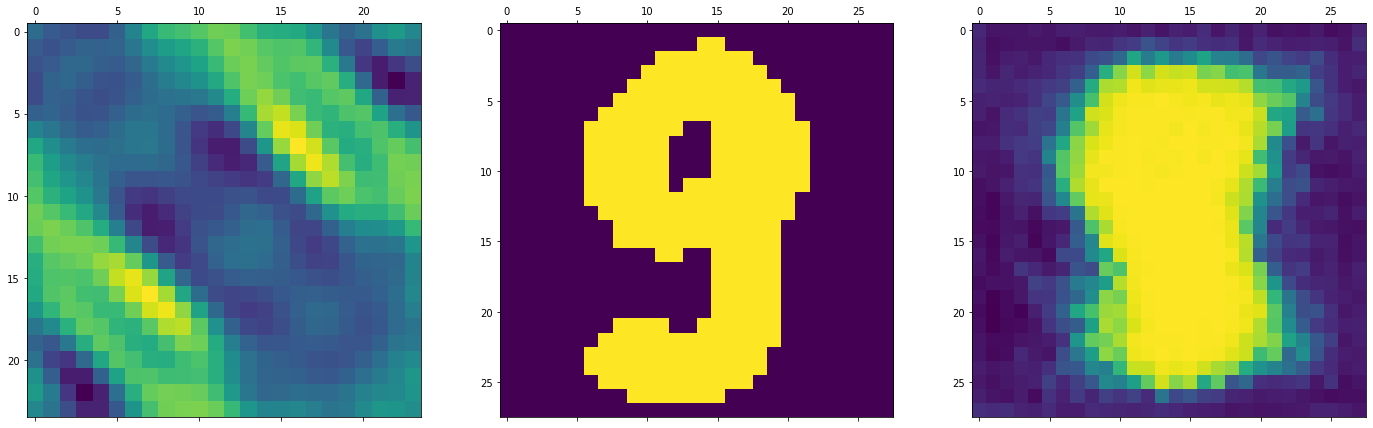

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[5])
axs[1].matshow(targetMNIST_test[5])
axs[2].matshow(pred1[5])

plt.show()

In [23]:
# trained_model_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)
model_mnist_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)

4/4 [==============================] - 1s 135ms/step - loss: 0.1099 - accuracy: 0.8606


[0.10985703021287918, 0.860615074634552]

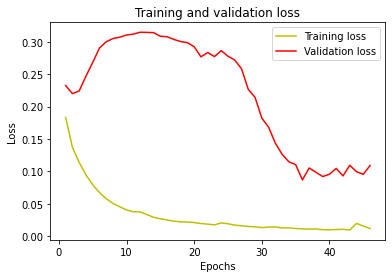

In [24]:
loss = hist_padded.history['loss']
val_loss = hist_padded.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

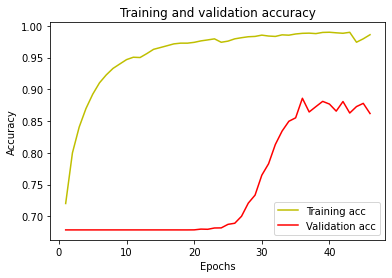

In [25]:
acc = hist_padded.history['accuracy']
val_acc = hist_padded.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

UNET with Flatten Layer to output 28x28 image

In [19]:
def unet_with_flatten(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    flatten = Flatten()(conv4)

    dense = Dense(28*28*1, activation='relu')(flatten)

    reshape = Reshape((28, 28, 1))(dense)

    # up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # conv5 = Conv2D(32, 3, padding='same')(up3)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)
    # conv5 = Conv2D(32, 3, padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)

    # conv5 = Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(reshape)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [17]:
inputMNIST_shape = fieldMNIST_train.shape[1:]
model_mnist_flatten = unet_with_flatten(inputMNIST_shape)
model_mnist_flatten.summary()

NameError: name 'unet_with_flatten' is not defined

In [21]:
checkpoint2 = tf.keras.callbacks.ModelCheckpoint("./model_weights_flatten/", monitor="val_loss", mode="min", save_best_only=True, 
                                                verbose=1, overwrite=True)
earlyStop2 = EarlyStopping(monitor='loss',patience=5)

model_mnist_flatten.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr), loss = 'binary_crossentropy', 
                    metrics = 'accuracy')
hist_flatten = model_mnist_flatten.fit(x = fieldMNIST_train, y = targetMNIST_train, validation_data=(fieldMNIST_val, targetMNIST_val), 
                       batch_size = 20, epochs = total_epoch, callbacks = [earlyStop2, checkpoint2])

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.7499
Epoch 1: val_loss improved from inf to 0.68925, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 24s 1s/step - loss: 0.6671 - accuracy: 0.7499 - val_loss: 0.6893 - val_accuracy: 0.6872
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.7963
Epoch 2: val_loss improved from 0.68925 to 0.68434, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 19s 924ms/step - loss: 0.6285 - accuracy: 0.7963 - val_loss: 0.6843 - val_accuracy: 0.6944
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.8110
Epoch 3: val_loss improved from 0.68434 to 0.68058, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 831ms/step - loss: 0.6085 - accuracy: 0.8110 - val_loss: 0.6806 - val_accuracy: 0.6909
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.8184
Epoch 4: val_loss improved from 0.68058 to 0.67674, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 16s 795ms/step - loss: 0.5942 - accuracy: 0.8184 - val_loss: 0.6767 - val_accuracy: 0.6938
Epoch 5/200
21/21 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.8243
Epoch 5: val_loss improved from 0.67674 to 0.67514, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 817ms/step - loss: 0.5804 - accuracy: 0.8243 - val_loss: 0.6751 - val_accuracy: 0.6937
Epoch 6/200
21/21 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.8284
Epoch 6: val_loss improved from 0.67514 to 0.67496, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 16s 775ms/step - loss: 0.5698 - accuracy: 0.8284 - val_loss: 0.6750 - val_accuracy: 0.6954
Epoch 7/200
21/21 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.8326
Epoch 7: val_loss improved from 0.67496 to 0.67457, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 835ms/step - loss: 0.5591 - accuracy: 0.8326 - val_loss: 0.6746 - val_accuracy: 0.6956
Epoch 8/200
21/21 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.8353
Epoch 8: val_loss did not improve from 0.67457
21/21 [==============================] - 12s 571ms/step - loss: 0.5510 - accuracy: 0.8353 - val_loss: 0.6764 - val_accuracy: 0.6951
Epoch 9/200
21/21 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.8372
Epoch 9: val_loss did not improve from 0.67457
21/21 [==============================] - 13s 612ms/step - loss: 0.5434 - accuracy: 0.8372 - val_loss: 0.6859 - val_accuracy: 0.6959
Epoch 10/200
21/21 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.8398
Epoch 10: val_loss did not improve from 0.67457
21/21 [==============================] - 12s 561ms/step - loss: 0.5364 - accuracy: 0.8398 - val_loss: 0.6811 - val_accuracy: 0.6958
Epoch 11/200
21/21 [========================

INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 827ms/step - loss: 0.4860 - accuracy: 0.8471 - val_loss: 0.6614 - val_accuracy: 0.7132
Epoch 22/200
21/21 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8471
Epoch 22: val_loss did not improve from 0.66143
21/21 [==============================] - 14s 666ms/step - loss: 0.4831 - accuracy: 0.8471 - val_loss: 0.6644 - val_accuracy: 0.7163
Epoch 23/200
21/21 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8468
Epoch 23: val_loss improved from 0.66143 to 0.65872, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 22s 1s/step - loss: 0.4806 - accuracy: 0.8468 - val_loss: 0.6587 - val_accuracy: 0.7199
Epoch 24/200
21/21 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8462
Epoch 24: val_loss improved from 0.65872 to 0.65152, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 849ms/step - loss: 0.4785 - accuracy: 0.8462 - val_loss: 0.6515 - val_accuracy: 0.7260
Epoch 25/200
21/21 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8469
Epoch 25: val_loss improved from 0.65152 to 0.63410, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 18s 895ms/step - loss: 0.4746 - accuracy: 0.8469 - val_loss: 0.6341 - val_accuracy: 0.7302
Epoch 26/200
21/21 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.8477
Epoch 26: val_loss improved from 0.63410 to 0.62820, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 20s 960ms/step - loss: 0.4707 - accuracy: 0.8477 - val_loss: 0.6282 - val_accuracy: 0.7421
Epoch 27/200
21/21 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8482
Epoch 27: val_loss improved from 0.62820 to 0.60946, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 21s 996ms/step - loss: 0.4671 - accuracy: 0.8482 - val_loss: 0.6095 - val_accuracy: 0.7545
Epoch 28/200
21/21 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.8484
Epoch 28: val_loss improved from 0.60946 to 0.60116, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 23s 1s/step - loss: 0.4643 - accuracy: 0.8484 - val_loss: 0.6012 - val_accuracy: 0.7638
Epoch 29/200
21/21 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.8477
Epoch 29: val_loss did not improve from 0.60116
21/21 [==============================] - 13s 621ms/step - loss: 0.4628 - accuracy: 0.8477 - val_loss: 0.6051 - val_accuracy: 0.7679
Epoch 30/200
21/21 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8482
Epoch 30: val_loss improved from 0.60116 to 0.58413, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 19s 937ms/step - loss: 0.4597 - accuracy: 0.8482 - val_loss: 0.5841 - val_accuracy: 0.7738
Epoch 31/200
21/21 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8484
Epoch 31: val_loss improved from 0.58413 to 0.56499, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 18s 857ms/step - loss: 0.4569 - accuracy: 0.8484 - val_loss: 0.5650 - val_accuracy: 0.7921
Epoch 32/200
21/21 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8485
Epoch 32: val_loss improved from 0.56499 to 0.56047, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 19s 930ms/step - loss: 0.4545 - accuracy: 0.8485 - val_loss: 0.5605 - val_accuracy: 0.8020
Epoch 33/200
21/21 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8483
Epoch 33: val_loss improved from 0.56047 to 0.56043, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 21s 1s/step - loss: 0.4527 - accuracy: 0.8483 - val_loss: 0.5604 - val_accuracy: 0.8079
Epoch 34/200
21/21 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8486
Epoch 34: val_loss did not improve from 0.56043
21/21 [==============================] - 16s 772ms/step - loss: 0.4501 - accuracy: 0.8486 - val_loss: 0.5613 - val_accuracy: 0.8113
Epoch 35/200
21/21 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8487
Epoch 35: val_loss improved from 0.56043 to 0.55083, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 21s 1s/step - loss: 0.4478 - accuracy: 0.8487 - val_loss: 0.5508 - val_accuracy: 0.8116
Epoch 36/200
21/21 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8488
Epoch 36: val_loss did not improve from 0.55083
21/21 [==============================] - 15s 717ms/step - loss: 0.4456 - accuracy: 0.8488 - val_loss: 0.5513 - val_accuracy: 0.8105
Epoch 37/200
21/21 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.8484
Epoch 37: val_loss did not improve from 0.55083
21/21 [==============================] - 14s 682ms/step - loss: 0.4442 - accuracy: 0.8484 - val_loss: 0.5697 - val_accuracy: 0.8121
Epoch 38/200
21/21 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8488
Epoch 38: val_loss did not improve from 0.55083
21/21 [==============================] - 13s 641ms/step - loss: 0.4418 - accuracy: 0.8488 - val_loss: 0.5608 - val_accuracy: 0.8127
Epoch 39/200
21/21 [=======================

INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 18s 861ms/step - loss: 0.4083 - accuracy: 0.8488 - val_loss: 0.5490 - val_accuracy: 0.8136
Epoch 67/200
21/21 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8491
Epoch 67: val_loss did not improve from 0.54897
21/21 [==============================] - 13s 612ms/step - loss: 0.4072 - accuracy: 0.8491 - val_loss: 0.5577 - val_accuracy: 0.8126
Epoch 68/200
21/21 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8493
Epoch 68: val_loss did not improve from 0.54897
21/21 [==============================] - 12s 573ms/step - loss: 0.4062 - accuracy: 0.8493 - val_loss: 0.5660 - val_accuracy: 0.8139
Epoch 69/200
21/21 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8495
Epoch 69: val_loss did not improve from 0.54897
21/21 [==============================] - 12s 551ms/step - loss: 0.4052 - accuracy: 0.8495 - val_loss: 0.5818 - val_accuracy: 0.8144
Epoch 70/200
21/21 [====================

In [22]:
model_mnist_flatten.save('unet_flatten.h5', overwrite=True)

trained_model_flatten = load_model('unet_flatten.h5')

In [25]:
pred2 = trained_model_flatten.predict(fieldMNIST_test)

4/4 [==============================] - 1s 107ms/step


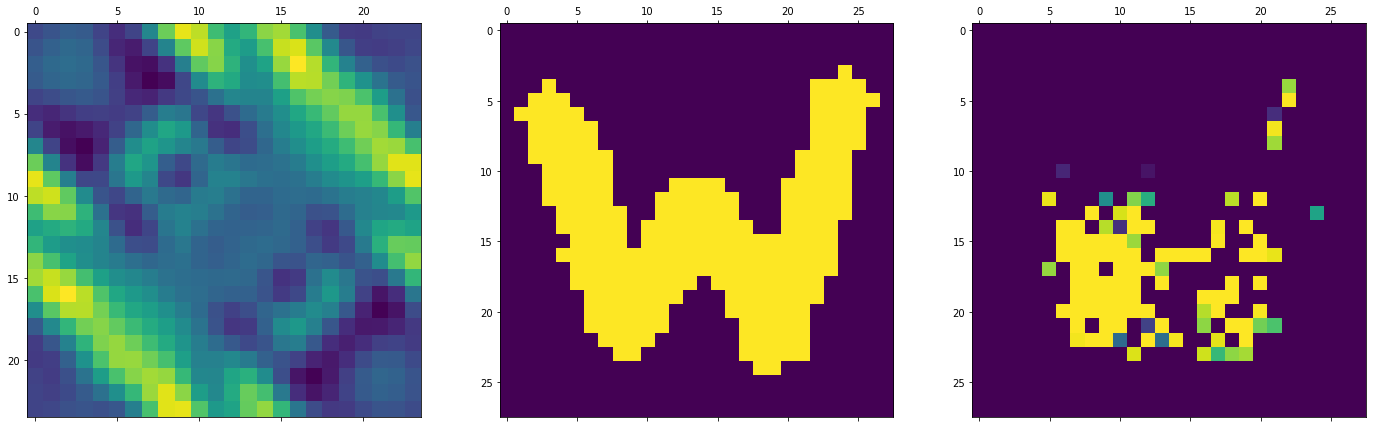

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[0])
axs[1].matshow(targetMNIST_test[0])
axs[2].matshow(pred2[0])

plt.show()

In [23]:
trained_model_flatten.evaluate(fieldMNIST_test, targetMNIST_test)

4/4 [==============================] - 3s 116ms/step - loss: 0.5876 - accuracy: 0.8151


[0.5875673890113831, 0.8150712847709656]

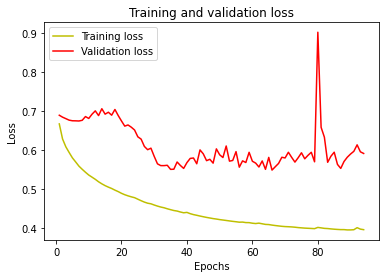

In [29]:
loss = hist_flatten.history['loss']
val_loss = hist_flatten.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

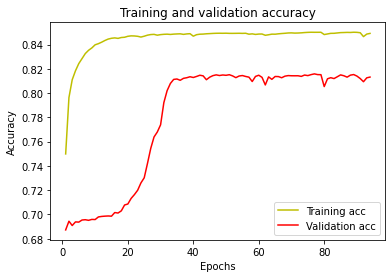

In [30]:
acc = hist_flatten.history['accuracy']
val_acc = hist_flatten.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Parameter search for both models

In [31]:
from sklearn.model_selection import GridSearchCV

In [66]:
model_mnist_padded.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6), loss = 'binary_crossentropy', 
                    metrics = 'accuracy')
hist_padded2 = model_mnist_padded.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 20, epochs = total_epoch, 
                                    callbacks = [EarlyStopping(monitor='val_loss',patience=10)])

Epoch 1/200
21/21 [==============================] - 11s 398ms/step - loss: 0.9656 - accuracy: 0.3493 - val_loss: 0.7161 - val_accuracy: 0.3215
Epoch 2/200
21/21 [==============================] - 8s 362ms/step - loss: 0.9521 - accuracy: 0.3523 - val_loss: 0.7368 - val_accuracy: 0.3215
Epoch 3/200
18/21 [========================>.....] - ETA: 1s - loss: 0.9405 - accuracy: 0.3563

KeyboardInterrupt: 

In [40]:
model_mnist_padded.save('unet_testing.h5', overwrite=True)

trained_model_cross_entropy = load_model('unet_testing.h5')

In [48]:
pred3 = model_mnist_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 1s 124ms/step


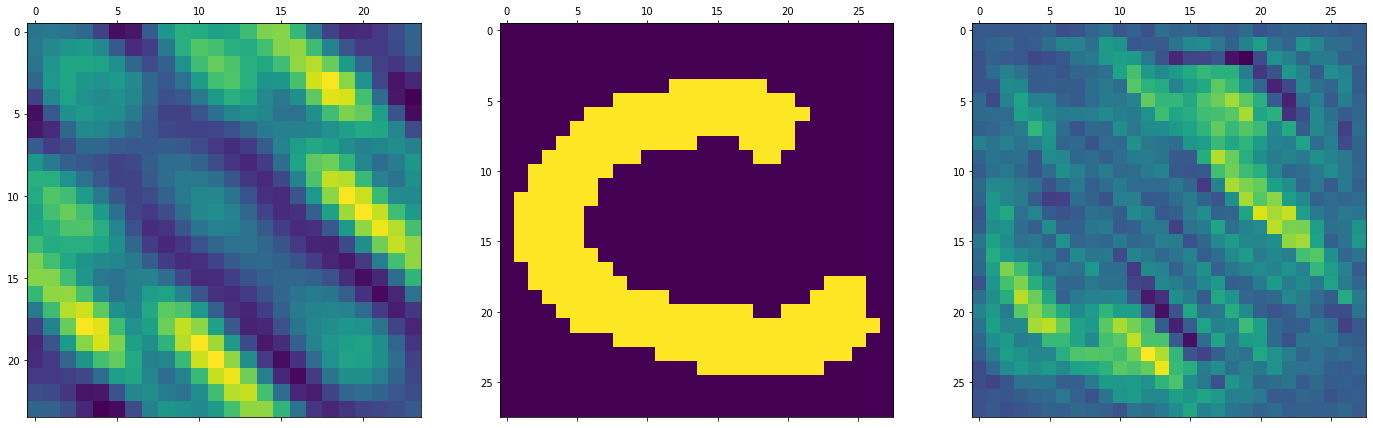

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[50])
axs[1].matshow(targetMNIST_test[50])
axs[2].matshow(pred3[50])

plt.show()

In [50]:
model_mnist_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

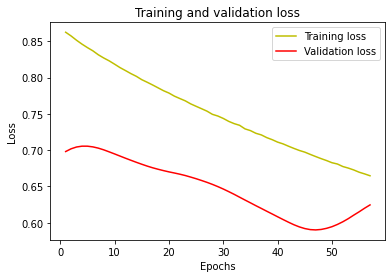

In [64]:
loss = hist_padded2.history['loss']
val_loss = hist_padded2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

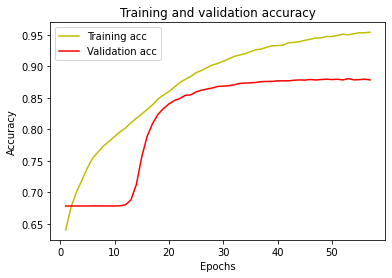

In [53]:
acc = hist_padded2.history['accuracy']
val_acc = hist_padded2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()